In [1]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
import uproot.models
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree
from  ana_tools import *


plt.rcParams.update({'font.size': 23,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

anatree:Anatree
mcstree:uproot.models.TTree.Model_TTree_v20
mcsangle:pl.DataFrame
dfana:pl.DataFrame

In [695]:
import uproot.models
import uproot.models.TTree


# def get_dump(fname):

#     # mcstree:uproot.models.TTree.Model_TTree_v20
#     mcstree = uproot.open(fname)

#     arr={}
    
#     alldata:ak.Array
#     alldata = mcstree.arrays()
#     top = len(alldata)

#     klist = ['run','subrun','event','isContained','len','trkpdg','E']
#     nevts = [len(v) for v in alldata['azx'][:top]]
#     for c in klist:
#         if c in alldata.fields:
#             a  = alldata[c][:top]
#             arr[c] = np.repeat(a,nevts)
        
#     ei = []
#     ej = []
#     for n in tqdm(nevts):
#         _ei = np.arange(0,n*10,10)
#         ei.append(_ei)
#         ej.append(_ei+10)
#     arr['ei'] = ak.ravel(ei)
#     arr['ej'] = ak.ravel(ej)
            
#     klist = ['azx','azy','avalid']
#     for c in klist:
#         a  = alldata[c][:top]
#         arr[c] = ak.ravel(a)
    
#     tangles = pd.DataFrame(arr)
#     dfret = pl.from_pandas(tangles)
#     dfret = dfret.with_columns(
#         p = (pl.col("E")**2 - 0.1057**2).sqrt()
#     )
#     return dfret

# mcs = get_dump('../data/dump_using_reco2.root:t1')
# mcssp = get_dump('../data/dump_using_sp2.root:t1')

# mcs.write_parquet("../data/parquet_dump_reco/parquet_dump_reco.parquet")
# mcssp.write_parquet("../data/parquet_dump_sp/parquet_dump_sp.parquet")

# mcsangle = mcsangle.with_columns(
#     ei = pl.col('ei'),
#     ej = pl.col('ej'),
# # ).with_columns(
# #     Ei = pl.col("E") - pl.col("ei")
# ).sort(selection_events())

100%|██████████| 126791/126791 [00:00<00:00, 565589.44it/s]


In [696]:
mcs = pl.read_parquet('../data/parquet_dump_reco/parquet_dump_reco.parquet')
mcssp = pl.read_parquet('../data/parquet_dump_sp/parquet_dump_sp.parquet')
mcs = mcs.sort(selection_events())
mcssp = mcssp.sort(selection_events())

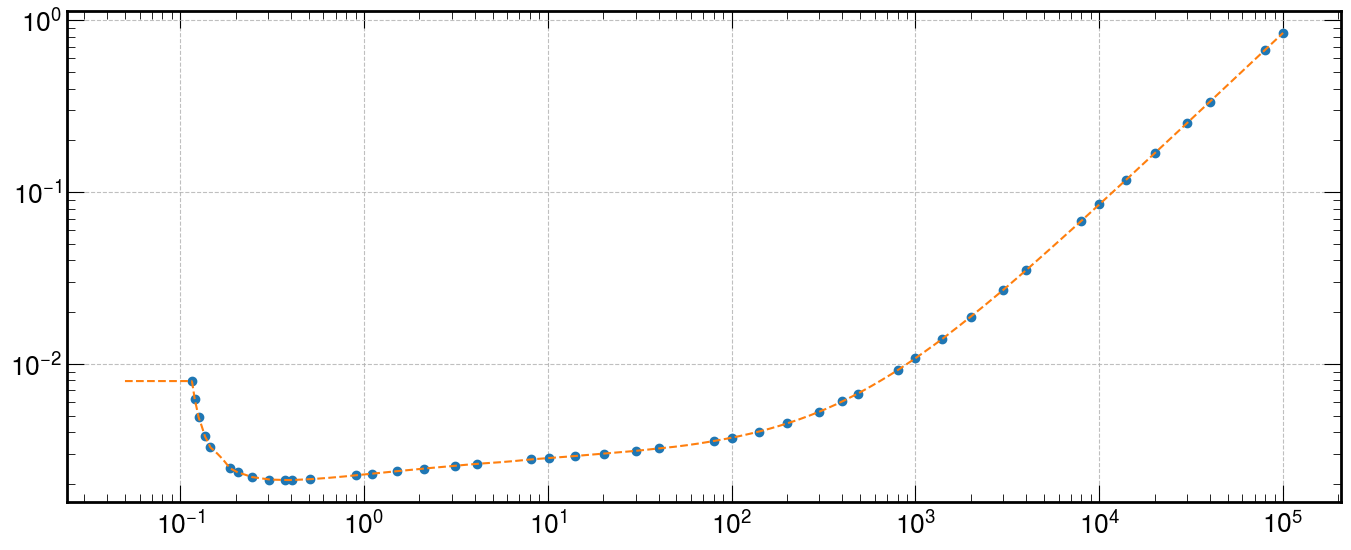

In [697]:
# 
dEdx = np.array([
    5.687, 4.461, 3.502, 2.731, 2.340, 1.771, 1.670, 1.570, 1.519, 1.508,
    1.510, 1.526, 1.610, 1.645, 1.700, 1.761, 1.829, 1.877, 1.991, 2.028,
    2.084, 2.149, 2.232, 2.304, 2.548, 2.663, 2.888, 3.224, 3.774, 4.332,
    4.808, 6.585, 7.730, 10.015, 13.494, 19.288, 25.147, 48.769, 60.675,
    84.472, 120.406, 180.375, 240.642, 482.918, 604.590, 
])*1.396*1e-3
E_GeV = np.array([
    0.115695, 0.119693, 0.125695, 0.135694, 0.145714, 0.185714, 0.205644,
    0.245698, 0.305658, 0.372031, 0.405711, 0.505671, 0.905689, 1.10606,
    1.50571, 2.10565, 3.1058, 4.10536, 8.10569, 10.1106, 14.1104, 20.1103,
    30.1102, 40.1101, 80.1101, 100.1, 140.1, 200.1, 300.1, 400.1, 484.6,
    800.1, 1000.0, 1400.0, 2000.0, 3000.0, 4000.0, 8000.0, 10000.0, 14000.0,
    20000.0, 30000.0, 40000.0, 80000.0, 1e+05
])
from scipy.interpolate import CubicSpline
# dEdx_vs_E = CubicSpline(E_GeV,dEdx)
E_inter = np.logspace(np.log10(0.05),5,2000)
dEdx_vs_E = np.interp(x=E_inter, xp=E_GeV, fp=dEdx)

plt.plot(E_GeV, dEdx, 'o')
plt.plot(E_inter, dEdx_vs_E, '--')
plt.yscale('log')
plt.xscale('log')


In [698]:
import numba as nb
@nb.njit
def compute_eloss(E, ei, ej):
    Eij = []
    Ej = []
    Elost = []
    _dEj=0
    _Elost = 0
    aux=0
    for Eref, step, nextstep in zip(E, ei, ej):
        if step==0:
            if _Elost != 0:
                for _ in range(aux):
                    Elost.append(_Elost)
            _Eij  = Eref
            _dEj = 0
            _Elost = 0
            _Ej = 0
            aux = 1
        else:
            _Eij = _Ej
            aux+=1
        _dEj = np.interp(_Eij, E_GeV, dEdx)*10
        _Elost += _dEj
        _Ej = _Eij - _dEj
        Eij.append(_Eij)
        Ej.append(_Ej)

    for _ in range(aux):
        Elost.append(_Elost)
    return Eij, Ej, Elost


In [719]:
pl.Config().set_tbl_rows(20)
pl.Config().set_tbl_cols(20)
def create_a_loss(df:pl.DataFrame):
    mcsret = df.sort(selection_events('ei'))
    tmp = mcsret.select(selection_events(['E', 'ei','ej' ]))
    arrtmp = tmp.to_dict()
    arr = {}
    for k in arrtmp.keys():
        arr[k] = arrtmp[k].to_numpy()
    Eij, Ej, Elost = compute_eloss(arr['E'], arr['ei'], arr['ej'])
    arr['Ei'] = np.array(Eij)
    arr['Ej'] = np.array(Ej)
    arr['Elost'] = np.array(Elost)
    tmppd = pd.DataFrame(arr)
    plEi = pl.from_pandas(tmppd)
    plEi = plEi.select(selection_events(['ei', 'Ei', 'Ej','Elost' ]))
    mcsret = mcsret.join(plEi, on=selection_events('ei'), how='inner')
    return mcsret
mcsangle = create_a_loss(mcs)
mcsanglesp = create_a_loss(mcssp)

In [720]:
tmpcount = mcsangle.sort(
    selection_events('ei')
).group_by(selection_events()).agg(
    pl.len(),
)
tmp = mcsangle.join(tmpcount, on=selection_events())
tmp.filter(
    pl.col("Ei")<0.1057
).group_by(selection_events()).agg(
    total = pl.col('len').first(),
    minors=pl.len(),
    E=pl.col('E').first()
).with_columns(
    frac = pl.col('minors')/pl.col('total')
)


run,subrun,event,total,minors,E,frac
i32,i32,i32,f64,u32,f64,f64
1500,1,76927,74.901568,3,0.180938,0.040053
1497,1,86276,243.833097,7,0.45146,0.028708
1498,1,17714,57.849796,2,0.158475,0.034572
1794,1,69710,73.055119,2,0.17262,0.027377
1794,1,92463,82.238434,2,0.225143,0.02432
1497,1,13813,1043.871768,1,2.480297,0.000958
1793,1,71621,78.961116,1,0.237041,0.012664
1793,1,90131,693.218759,1,1.613213,0.001443
50231162,1,86286,45.704733,2,0.133425,0.043759


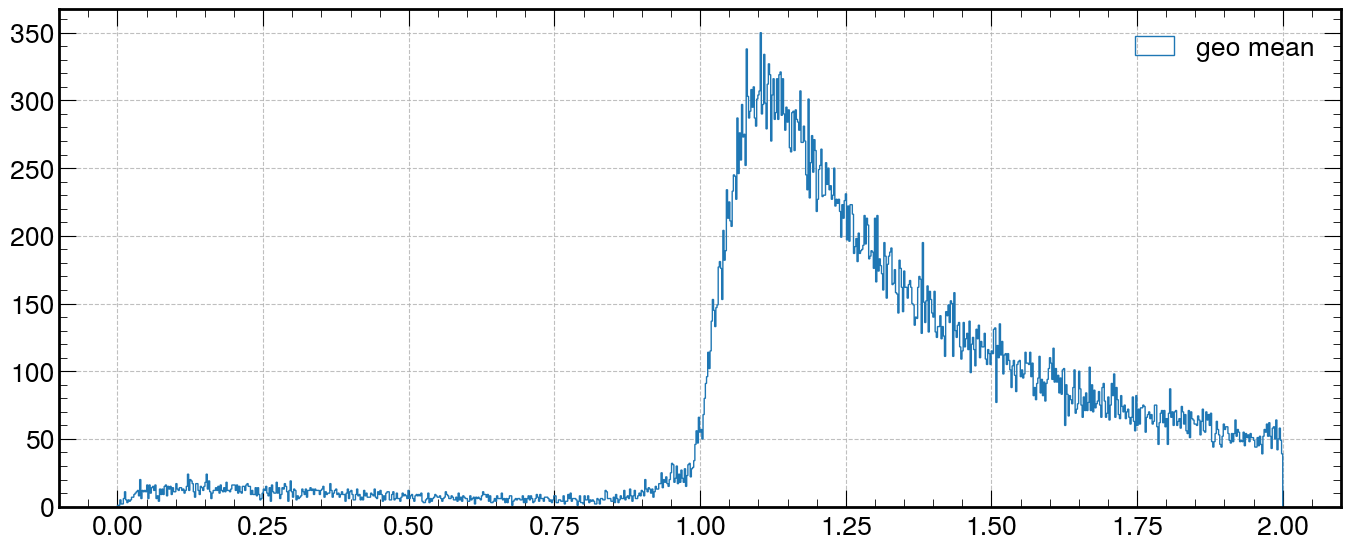

In [721]:
dftmp = mcsangle.sort(selection_events('ei')).group_by(selection_events()).agg(
    pl.col("isContained").last(),
    E = pl.col("E").last()-0.1057,
    Elost = pl.col("Elost").last(),# - pl.col('Ei').last(),
    nsteps = pl.col('ei').len(),
    ei = pl.col('ei').first(),
).with_columns(
    diff = ((pl.col("E"))/pl.col('Elost')),
# ).filter(pl.col("isContained")
# ).filter(
#     pl.col('ei') < 30
)
plt.hist(dftmp['diff'], bins=np.linspace(0.,2,1000), histtype='step', label='geo mean');
plt.legend()
# plt.xscale('log')
mcsangle = mcsangle.join(dftmp.select(selection_events(['diff','nsteps'])), on=selection_events())

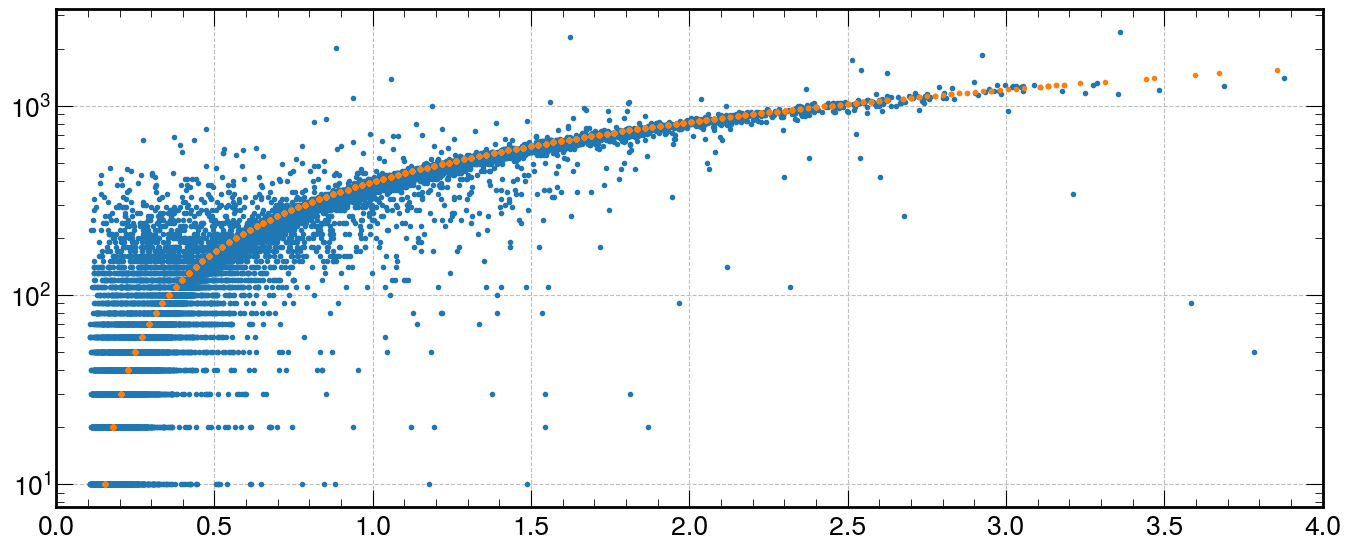

In [722]:
len_cm = np.array([9.833E-1, 1.786E0, 3.321E0, 6.598E0, 1.058E1,
          3.084E1, 4.250E1, 6.732E1, 1.063E2, 1.725E2,
          2.385E2, 4.934E2, 6.163E2, 8.552E2, 1.202E3,
          1.758E3, 2.297E3, 4.359E3, 5.354E3, 7.298E3, 1.013E4, 1.469E4, 1.910E4, 3.558E4, 4.326E4, 5.768E4, 7.734E4, 1.060E5, 1.307E5])/1.396
 
KE_GeV = np.array([10, 14, 20, 30, 40, 80, 100, 140, 200, 300, 400, 800, 1000, 1400, 2000, 3000,
          4000, 8000, 10000, 14000, 20000, 30000, 40000, 80000, 100000, 140000,
          200000, 300000, 400000])/1e3
from scipy.interpolate import CubicSpline
KE_by_len = CubicSpline(len_cm,KE_GeV)
tmp = mcsangle.group_by(selection_events()).agg(
    pl.col('E').first(),
    pl.col('isContained').first(),
    pl.len()*10,
).filter(pl.col('isContained')).with_columns(
    Erange = pl.col('len').map_elements(lambda x: KE_by_len(x), return_dtype=pl.Float32) + 0.1057
)
plt.plot(tmp['E'],tmp['len'],'.')
plt.plot(tmp['Erange'],tmp['len'],'.')
plt.xlim(0,4)
# plt.xscale('log')
plt.yscale('log')

/home/henrique/.local/lib/python3.10/site-packages/polars/series/series.py:1416: RuntimeWarning: invalid value encountered in sqrt
  lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs),
/tmp/ipykernel_1370974/719409218.py:34: RuntimeWarning: divide by zero encountered in divide
  popt, pcov = curve_fit(gaus,hycenters, hh[aux],p0=[0,20,20], sigma=1/np.sqrt(hh[aux]))
/tmp/ipykernel_1370974/719409218.py:45: RuntimeWarning: divide by zero encountered in divide
  popt, pcov = curve_fit(gaus,hycenters, v,p0=[0,20,20], sigma=1/np.sqrt(v))


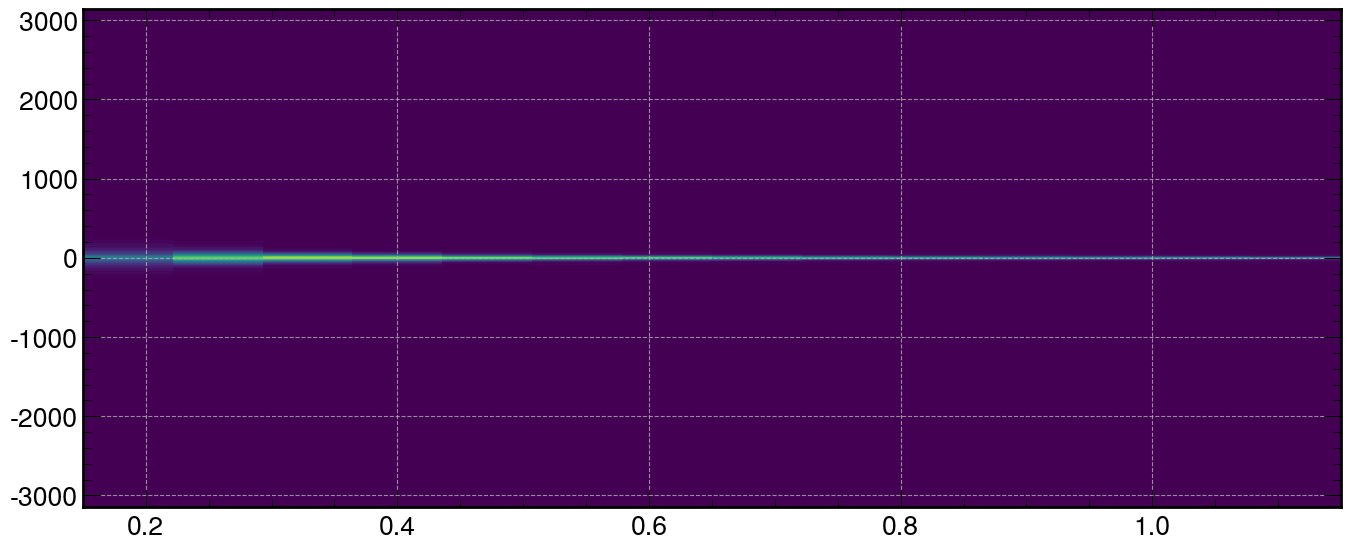

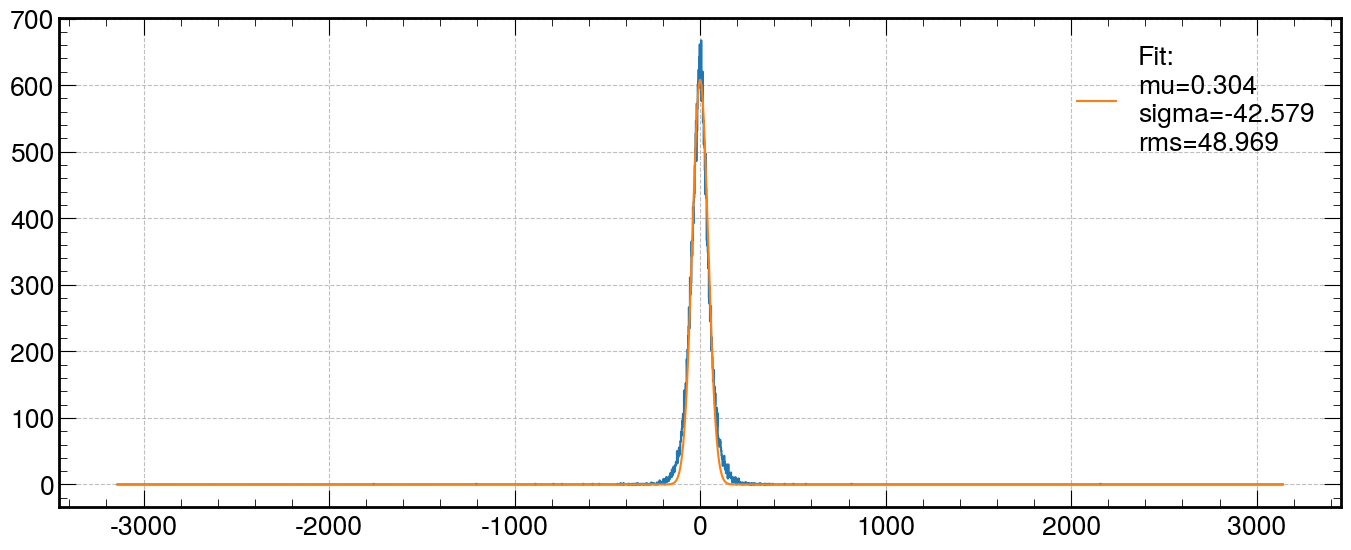

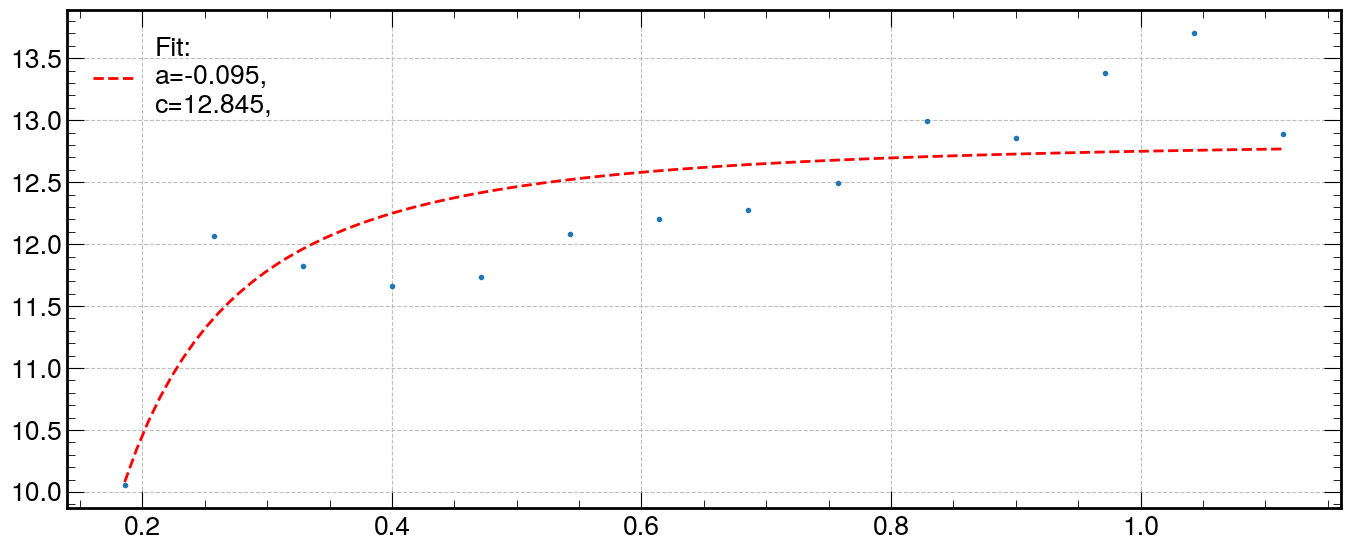

In [703]:
from scipy.optimize import curve_fit
def gaus(x, u, s, a):
    return (a/np.sqrt(2*np.pi*s*s))*np.exp(-((x-u)/s)**2/2)

def fit_s2(x, a, c):
    return (a/x**2+c)

def compute_s2(p, rms):
    rad_length = 14.0
    stepsize = 10
    red_length = stepsize / rad_length
    m_muon = 0.1057
    beta = np.sqrt(1 - ((m_muon*m_muon)/(p*p + m_muon*m_muon)))
    const =  (1.0 + 0.038 * np.log(red_length/beta**2)) * np.sqrt(red_length)
    return p*beta*rms/const

dfc = mcsangle.filter(
    pl.col('avalid') == True
).filter(
    pl.col('ei') < 30
)
# binsx = np.logspace(np.log10(0.15),np.log10(2),50)
binsx = np.linspace(0.15,1.15,15)
rms, _, _ = binned_statistic(np.sqrt(dfc['Ei']**2-0.1057**2), dfc['azx'], "std", binsx)
bins_center = 0.5*(binsx[:-1] + binsx[1:])
bins_width = binsx[1:]- binsx[:-1]
hh, hxe, hye, _ = plt.hist2d(dfc['p'], dfc['azx']/0.7, bins=[binsx, np.linspace(-3141.5,3141.5,3141)] );
# plt.xscale('log')


aux = 1
plt.figure()
hycenters = (hye[:-1] + hye[1:])*0.5
plt.step(hycenters, hh[aux])
popt, pcov = curve_fit(gaus,hycenters, hh[aux],p0=[0,20,20], sigma=1/np.sqrt(hh[aux]))
plt.plot(hycenters, gaus(hycenters, *popt), label = f"Fit:\nmu={popt[0]:5.3f}\nsigma={popt[1]:5.3f}\nrms={rms[aux]:5.3f}")
plt.legend()


plt.figure()
nanrms = rms[~np.isnan(rms)]
nancenters = bins_center[~np.isnan(rms)]
nancenters = (hxe[:-1] + hxe[1:])*0.5
nanrms = []
for v in hh:
    popt, pcov = curve_fit(gaus,hycenters, v,p0=[0,20,20], sigma=1/np.sqrt(v))
    nanrms.append(abs(popt[1]))
    
s2 = compute_s2(nancenters, nanrms)
plt.plot(nancenters, s2, '.' )
popt, pcov = curve_fit(fit_s2, nancenters, s2, p0=[0.1,11])#, sigma=1/np.sqrt(heigths))
# plt.plot(nancenters, func(nanrms, *[0.1,11]), 'r--', label="Fit:\n" r"$\mu$=%5.3f," "\n" r"$\sigma$=%5.3f," % tuple(popt[:2]), lw=2)
nancenterfit = np.linspace(nancenters[0], nancenters[-1],100)
plt.plot(nancenterfit, fit_s2(nancenterfit, *popt), 'r--', label="Fit:\n" r"a=%5.3f," "\n" r"c=%5.3f," % tuple(popt), lw=2)
plt.legend()
# plt.xscale('log')



/home/henrique/.local/lib/python3.10/site-packages/polars/series/series.py:1416: RuntimeWarning: invalid value encountered in sqrt
  lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs),


5.950983669424407

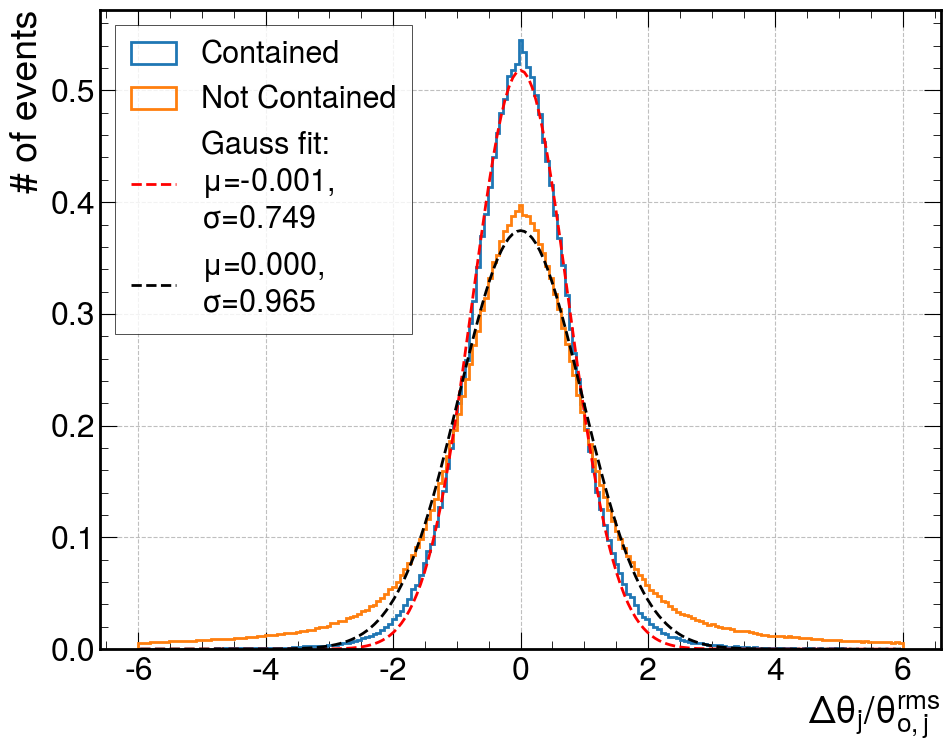

In [841]:
def compute_rms(p=None, _ei=None):
    if p is None: 
        p = pl.col('p')
    if _ei is None: 
        # _ei = pl.col('ei'root)
        _ei = pl.col('Ei')
    
    a = 0.129
    c = 10.054

    rad_length = 14.0
    stepsize = 10
    red_length = stepsize / rad_length
    m_muon = 0.1057
    nonrel_Eij = _ei

    nonrel_pij = np.sqrt(nonrel_Eij*nonrel_Eij - m_muon*m_muon)
    beta = np.sqrt(1 - ((m_muon*m_muon)/(nonrel_pij*nonrel_pij + m_muon*m_muon)))
    tH0 = ( (a/nonrel_pij**2 + c) / (nonrel_pij*beta)) * (1.0 + 0.038 * np.log(red_length/beta**2)) * np.sqrt(red_length)
    return tH0

mcsangle = mcsangle.with_columns(
    rms = ( compute_rms()**2 + 0**2 ).sqrt(),
    theta = (pl.col('azx')**2 + pl.col('azy')**2).sqrt(),
    seg = (pl.col('ej')/0.0021)
)
mcsanglesp = mcsanglesp.with_columns(
    rms = ( compute_rms()**2 + 0**2 ).sqrt(),
    theta = (pl.col('azx')**2 + pl.col('azy')**2).sqrt(),
    seg = (pl.col('ej')/0.0021)
)

df = mcsangle
dfplot = df#.filter(pl.col("E")<1)#.filter((pl.col('azx')/pl.col('rms')).abs()>0.0007)

def create_dfplot(df, iscontained=True):
    
    dfplot = df.filter(
        pl.col("isContained") == iscontained
    ).filter(
        pl.col('avalid')== True
    ).filter(
        pl.col('trkpdg').abs() == 13
    )

    dfplotnotend = dfplot.group_by(selection_events()).agg(
        pl.col('ei').head(pl.col('ei').len())
        # pl.col('ei').tail(5)
    ).filter(
        pl.col('ei').len()>0
    ).explode('ei')
    dfplot = dfplot.join(dfplotnotend, on=selection_events('ei'))
    return dfplot
dfplot = create_dfplot(df, False)
dfplotc = create_dfplot(df, True)

plt.figure(figsize=(10,8))
binsx = np.linspace(-6,6,200)
# heigths, hedges, _ = plt.hist((dfplot['azy']/dfplot['rms'])*np.sqrt(2), bins=binsx, histtype='step', label=r'$\sqrt{2} \times \Delta\theta_{xz}/\theta^{rms}_o$',lw=2,color='k');
heigthsc, hedgesc, _ = plt.hist((dfplotc['azx']/dfplotc['rms']), bins=binsx, histtype='step', label=r'Contained',lw=2, density=True);
heigths, hedges, _ = plt.hist((dfplot['azx']/dfplot['rms']), bins=binsx, histtype='step', label=r'Not Contained',lw=2, density=True);
hcenters = (hedges[1:] + hedges[:-1])*0.5
# cfitlim = abs(hcenters)<1.5
# hcenters = hcenters[cfitlim]
# heigths = heigths[cfitlim]
poptc, pcovc = curve_fit(gaus, hcenters, heigthsc, p0=[0,1,35000])#, sigma=1/np.sqrt(heigths))
popt, pcov = curve_fit(gaus, hcenters, heigths, p0=[0,1,35000])#, sigma=1/np.sqrt(heigths))
perr = np.sqrt(np.diag(pcov))
perrc = np.sqrt(np.diag(pcovc))
# popt[1] = popt[1]/np.sqrt(2)
plt.plot(hcenters, gaus(hcenters, *poptc), 'r--', label="Gauss fit:\n" r"$\mu$=%5.3f," "\n" r"$\sigma$=%5.3f" % tuple(poptc[:2]), lw=2)
plt.plot(hcenters, gaus(hcenters, *popt), 'k--', label=r"$\mu$=%5.3f," "\n" r"$\sigma$=%5.3f" % tuple(popt[:2]), lw=2)
plt.tick_params(labelsize=23)
plt.xlabel(r'$\Delta\theta_j/\theta^{rms}_{o, j}$', fontsize=27)
plt.ylabel('# of events', fontsize=27)
# plt.yscale('log')
legend = plt.legend(frameon=True, fontsize=22, fancybox=False, loc='upper left')
legend.get_frame().set_edgecolor('k')
legend.get_frame().set_linewidth(0.6)
(dfplotc['azx']/dfplotc['rms']).drop_nans().std()


In [842]:
mcsangle.sort(
    selection_events('ei')
).select(selection_events(['isContained', 'theta','azx','azy','rms', 'avalid','E','Ei','ei'])).with_columns(
    deltatheta_over_rms = pl.col('azx')/pl.col('rms')
).filter(
    pl.col('isContained')==False
).filter(
    pl.col('deltatheta_over_rms').abs()>4
).head(100).tail(80)

run,subrun,event,isContained,theta,azx,azy,rms,avalid,E,Ei,ei,deltatheta_over_rms
i32,i32,i32,bool,f64,f64,f64,f64,bool,f64,f64,i64,f64
1453,1,94,false,106.131922,-27.227177,102.580045,1.23906,true,7.956381,6.773687,430,-21.974058
1453,1,94,false,175.184021,-37.442422,171.135929,1.244073,true,7.956381,6.746423,440,-30.096648
1453,1,94,false,131.070291,34.186192,126.533495,1.249124,true,7.956381,6.719169,450,27.368125
1453,1,127,false,28.176463,27.38357,6.637255,6.037975,true,1.406605,1.406605,0,4.535224
1453,1,148,false,8.623287,7.055966,-4.95726,0.871504,true,9.627888,9.627888,0,8.096304
1453,1,148,false,36.754671,-18.312602,-31.867765,0.874065,true,9.627888,9.599702,10,-20.951082
1453,1,148,false,15.151217,8.948044,12.226688,0.879229,true,9.627888,9.54335,30,10.177152
1453,1,148,false,5.612168,4.835964,2.847785,0.887085,true,9.627888,9.458878,60,5.451524
1453,1,148,false,18.955445,5.104272,18.255281,0.889734,false,9.627888,9.430735,70,5.736855


In [843]:
# Example bad reconstruction, 70,1 is a muons escaping, llhd and range give same result
dfsmalls = dfplot.group_by(selection_events()).agg(
    azx_total = pl.len(),
    azx_small = pl.col('azx').filter((pl.col('azx')/pl.col('rms')).abs()<0.07).count(),
    len = pl.col('len') .first(),
    E = pl.col('E').first()
).with_columns(
    frac = pl.col('azx_small')/pl.col('azx_total')
).filter(pl.col("azx_small")>0)
# df
dfsmalls.describe()

statistic,run,subrun,event,azx_total,azx_small,len,E,frac
str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",41925.0,41925.0,41925.0,41925.0,41925.0,41925.0,41925.0,41925.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",7.6058e6,1.0,48611.38161,40.316088,2.579273,422.475147,3.932016,0.089142
"""std""",1.8004e7,0.0,28930.390864,28.079905,1.962241,284.554836,6.791506,0.089816
"""min""",1453.0,1.0,1.0,1.0,1.0,20.086854,0.162412,0.006452
"""25%""",1499.0,1.0,23975.0,19.0,1.0,203.656529,0.909383,0.041667
"""50%""",1500.0,1.0,47881.0,34.0,2.0,359.82809,1.770378,0.066667
"""75%""",1794.0,1.0,73477.0,55.0,3.0,575.543032,3.871749,0.105263
"""max""",5.0231162e7,1.0,99995.0,175.0,27.0,2283.620331,90.536064,1.0


Text(0, 1, '# of events')

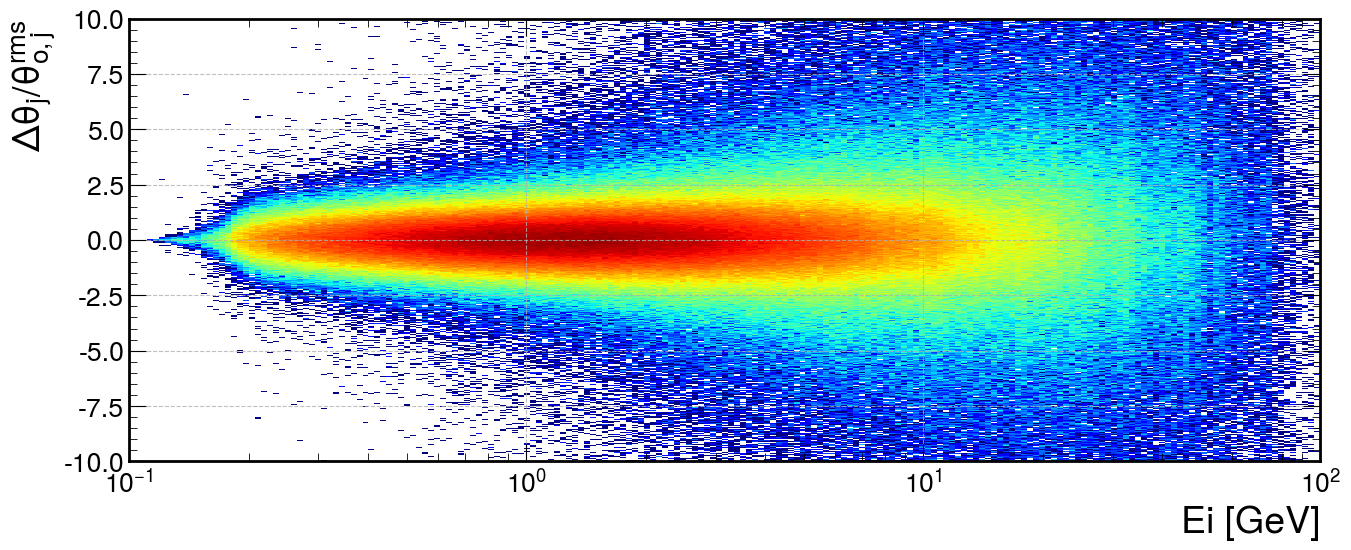

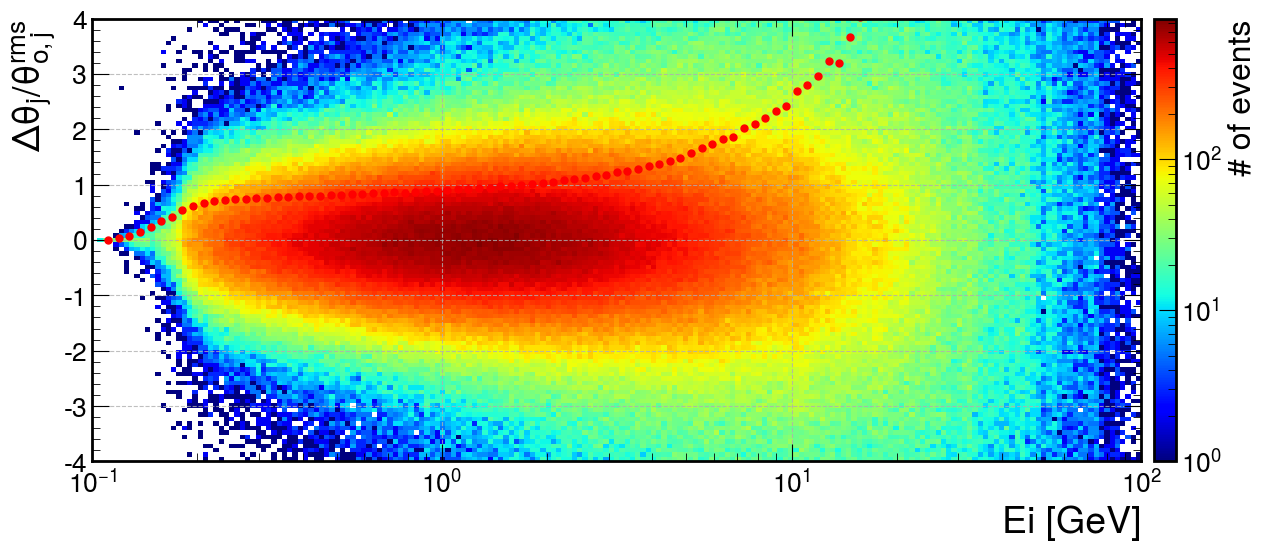

In [857]:

plt.hist2d(dfplot['Ei'], dfplot['azx']/dfplot['rms'], bins=[np.logspace(-1,2,200), np.linspace(-10,10,500)],cmap=plt.cm.jet, norm='log', label='Some');
plt.xlabel('Ei [GeV]', fontsize=27)
plt.ylabel(r'$\Delta\theta_j/\theta^{rms}_{o, j}$', fontsize=27)
plt.xscale('log')

plt.figure()
binsx = np.logspace(-1,2,100)
val, _, _ = binned_statistic(dfplot['Ei'], dfplot['azx']/dfplot['rms'], manual_std, binsx)
bins_center = 0.5*(binsx[:-1] + binsx[1:])
bins_width = binsx[1:]- binsx[:-1]
plt.hist2d(dfplot['Ei'], dfplot['azx']/dfplot['rms'], bins=[np.logspace(-1,2,200), np.linspace(-4,4,100)], cmap=plt.cm.jet, norm='log')
lines = plt.plot(bins_center, val, 'o', markersize=5, color='r',)
# plt.hist2d(dfplot['Ei'], dfplot['azx']/dfplot['rms'], bins=[np.logspace(-1,2,100), np.linspace(-10,10,100)], cmap=plt.cm.jet, cmin=1)
# fakeE = np.logspace(-1,2,200)
# fakeEi = np.zeros_like(fakeE)
# fakeRMS = compute_rms(fakeE, fakeEi)
# plt.plot(fakeE,fakeRMS, '--', color='red', lw=2)
plt.xlabel('Ei [GeV]', fontsize=27)
plt.ylabel(r'$\Delta\theta_j/\theta^{rms}_{o, j}$', fontsize=27)
# plt.ylabel(r'$\Delta\theta_{zx}$', fontsize=27)
plt.xscale('log')
cbar = plt.colorbar(pad=0.01)
cbar.ax.set_ylabel('# of events', fontsize=23)
# dfplot.filter(get_event(70,1))
# anatree.nu.filter(get_event(70,1))["RecoLepEnNumu_mcs_llhd"]

In [952]:
# pl.Config.oset_tbl_rows(40)

#     pl.count(),# plot_res_vs_energy(dftemp['E'],
#                    dftemp['RecoLepEnNumu_range'],
#                    label=r'CSDA')
#     pl.all(),
# ).explode(pl.all().exclude(selection_events(['count']))).sort('subrun').sort('count', descending=True).head(40)

def getvalues(df:pl.DataFrame):
    dfllhd = df.sort(selection_events('ei')).group_by(selection_events(),maintain_order=True).agg(
        pl.all().exclude('seg','len','p','trkpdg', 'isContained', 'E'),
        seg = pl.col('seg').first(),
        len = pl.col('len').first(),
        p = pl.col('p').first(),
        trkpdg = pl.col('trkpdg').first(),
        E = pl.col('E').first(),
        isContained = pl.col('isContained').first(),
        nvalids = pl.col('avalid').filter(pl.col('avalid')==True).len(),
    ).filter(
        pl.col('nvalids') > 0
    ).filter(
        pl.col('trkpdg').abs() == 13
    ).sort(selection_events())
    vals = dfllhd.select(['theta', 'ei', 'ej', 'p', 'subrun', 'event', 'azx', 'azy','len', 'avalid', 'run', 'isContained']).to_numpy(structured=True)
    return vals
vals = getvalues(mcsangle)
valssp = getvalues(mcsanglesp)

array([False, False])

In [953]:
import numba as nb
@nb.njit
def llhd(evDT, evValid, correct, p, res):
    # a = 0.1049
    # c = 11.0038
    a = 0.129
    c = 10.054

    rad_length = 14.0
    stepsize = 10
    red_length = stepsize / rad_length
    m_muon = 0.1057
    Etot = np.sqrt(p*p + m_muon*m_muon)

    result = 0
    dei = 0
    penality = False
    Eij = Etot
    for idx in nb.prange(len(evDT)):
        dth = evDT[idx]
        Eij = Eij - dei
        if Eij <= m_muon:
            penality=True
            Eij = m_muon+0.01
            dei = 0
        else:
            dei = np.interp(Eij, E_GeV, dEdx)*stepsize
        # if nonrel_Eij < m_muon:
        #     return 99999

        pij = np.sqrt(Eij*Eij - m_muon*m_muon)
        beta = np.sqrt(1 - ((m_muon*m_muon)/(pij*pij + m_muon*m_muon)))
        tH0 = ( (a/pij**2 + c) / (pij*beta)) * (1.0 + 0.038 * np.log(red_length/beta**2)) * np.sqrt(red_length)
        if correct:
            tH0 *= np.sqrt(2)
        rms_square = (tH0**2 + res**2)
        if evValid[idx] is False:
            continue
        prob = -0.5*np.log(2*np.pi) - 0.5*np.log(rms_square) - 0.5*dth*dth/rms_square
        if penality:
            prob -= 2*rms_square
        result-=2*prob
    return result
def call_llhd(p:float, res:float, ev:int):
    global DT
    global Valid
    global correct
    
    ev = int(ev)
    result = 0
    result = llhd(DT[ev], Valid[ev], correct, p, res)
    return result


idx: 77, run: 1453,  subrun: 1, event: 391, p = 0.26, contained = False


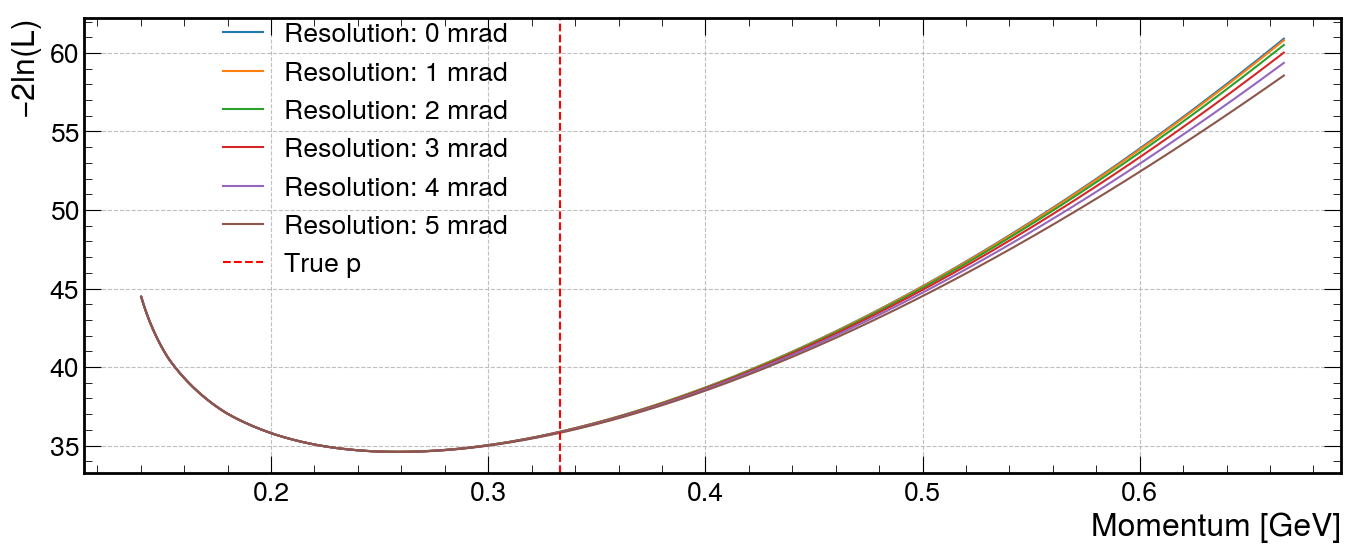

In [954]:
res_scan = [ r for r in range(0,6,1)]
res = [[] for _ in res_scan]
ptry = [[] for _ in res]
idx=77
DT = vals['theta']/0.751#[idx]/np.sqrt(2)
Valid = vals['avalid']
trueP = vals['p']
correct = True
# DT = azy[idx]
for r,i in enumerate(res_scan):
    Erange = KE_by_len(len(DT[idx])*10) + 0.1057
    Prange = np.sqrt(Erange**2 - 0.1057**2)
    for x in np.linspace(Prange*0.8, 2*trueP[idx], 400):
        ll = call_llhd(x, r, idx)
        res[i].append(ll)
        ptry[i].append(x)
    plt.plot(ptry[i], res[i], label=f"Resolution: {r:.0f} mrad")
# plt.yscale('log')
# plt.ylim(-1,2000)
plt.axvline(trueP[idx], color='r', linestyle='--', label='True p')
plt.ylabel(r'$-2ln(\mathcal{L})$')
plt.xlabel('Momentum [GeV]')
axbox = plt.gca().get_position
plt.legend(loc=(0.1,0.4),ncol=1)
print(f'idx: {idx}, run: {vals["run"][idx]},  subrun: {vals["subrun"][idx]}, event: {vals["event"][idx]}, p = {ptry[0][np.argmin(res[0])]:.2f}, contained = {vals["isContained"][idx]}')

In [955]:
from iminuit import Minuit, cost
from iminuit.util import describe


def lazy_min(start=0, maxevt=None, values = None , resval = 0, fixres = True, docorrect = True, angleadjust = 0.751):
    global trueP
    global DT
    global Valid
    global correct
    global trklen
    
    
    
    DT = values['theta']/angleadjust
    Valid = values['avalid']
    trklen = values['len']
    trueP = values['p']
    correct = docorrect
    
    indexes = [ i for i, _ in enumerate(trueP)]

    if maxevt == None:
        maxevt = len(trueP)
    p_ = trueP[start:maxevt]
    indexes = indexes[start:maxevt]
    
    trueE = np.zeros_like(p_)
    recoE = np.zeros_like(p_)
    fitS = np.zeros_like(p_)
    for idx, ev in enumerate(tqdm(indexes)):
        pt = p_[idx]
        pars = ['p', 'res', 'ev']
        Erange = KE_by_len(len(DT[idx])*10) + 0.1057
        Prange = np.sqrt(Erange**2 - 0.1057**2)
        m = Minuit(call_llhd, p=2*Prange, res=resval, ev=ev)
        m.tol = 0.01/2.
        m.fixed['ev'] = True
        m.limits['p']=(0.8*Prange,100)
        m.limits['res']=(0,100)
        m.fixed['res'] = fixres
        m.strategy.strategy = 2
        m.migrad()
        vals = [m.values[par] for par in pars]
        trueE[idx] = np.sqrt(pt**2 + 0.1057**2)
        recoE[idx] = np.sqrt(vals[0]**2 + 0.1057**2)
        fitS[idx] = m.fmin.is_valid
    trueE = trueE.astype(float)
    recoE = recoE.astype(float)
    return trueE, recoE , fitS


In [964]:
maxevt = None
trueE, recoE, fitS = lazy_min(0,maxevt, vals)
trueEsp, recoEsp, fitSsp = lazy_min(0,maxevt, vals, angleadjust=1)

100%|██████████| 116358/116358 [00:44<00:00, 2624.90it/s]


In [965]:
trueEc = trueE[vals['isContained'][:maxevt]==True]
recoEc = recoE[vals['isContained'][:maxevt]==True]
fitSc = fitS[vals['isContained'][:maxevt]==True]

trueE = trueE[vals['isContained'][:maxevt]==False]
recoE = recoE[vals['isContained'][:maxevt]==False]
fitS = fitS[vals['isContained'][:maxevt]==False]

trueEcsp = trueEsp[valssp['isContained'][:maxevt]==True]
recoEcsp = recoEsp[valssp['isContained'][:maxevt]==True]
fitScsp = fitSsp[valssp['isContained'][:maxevt]==True]

trueEsp = trueEsp[valssp['isContained'][:maxevt]==False]
recoEsp = recoEsp[valssp['isContained'][:maxevt]==False]
fitSsp = fitSsp[valssp['isContained'][:maxevt]==False]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 116358 but corresponding boolean dimension is 113335

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1400x600 with 0 Axes>

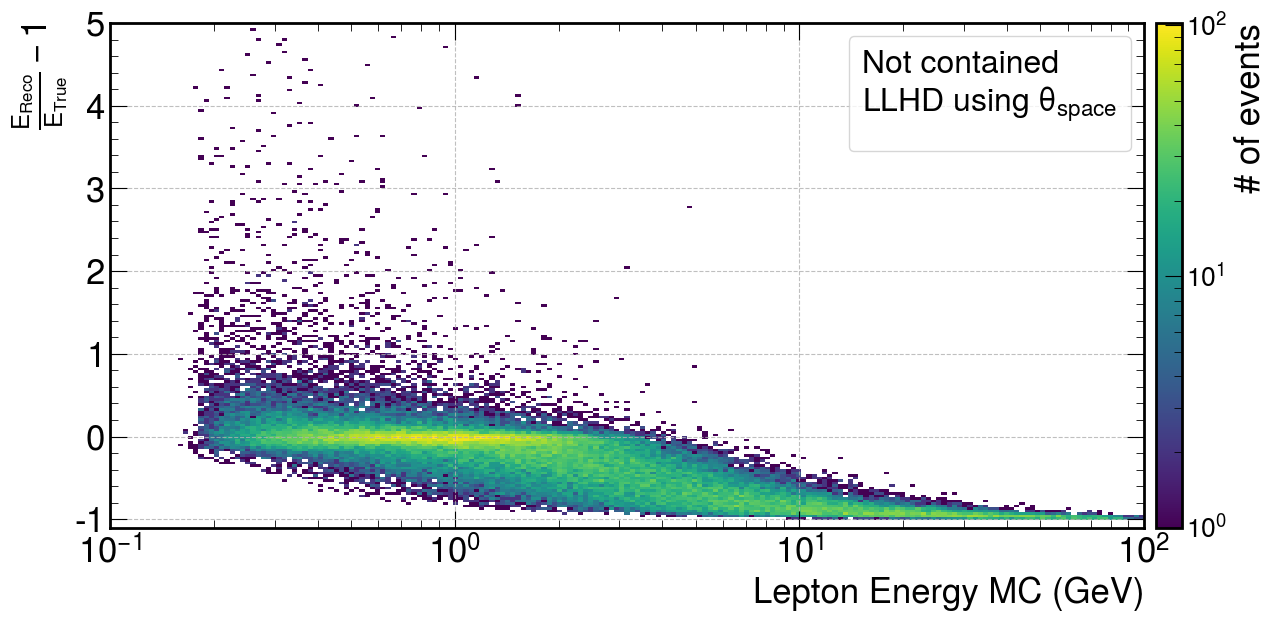

<Figure size 1400x600 with 0 Axes>

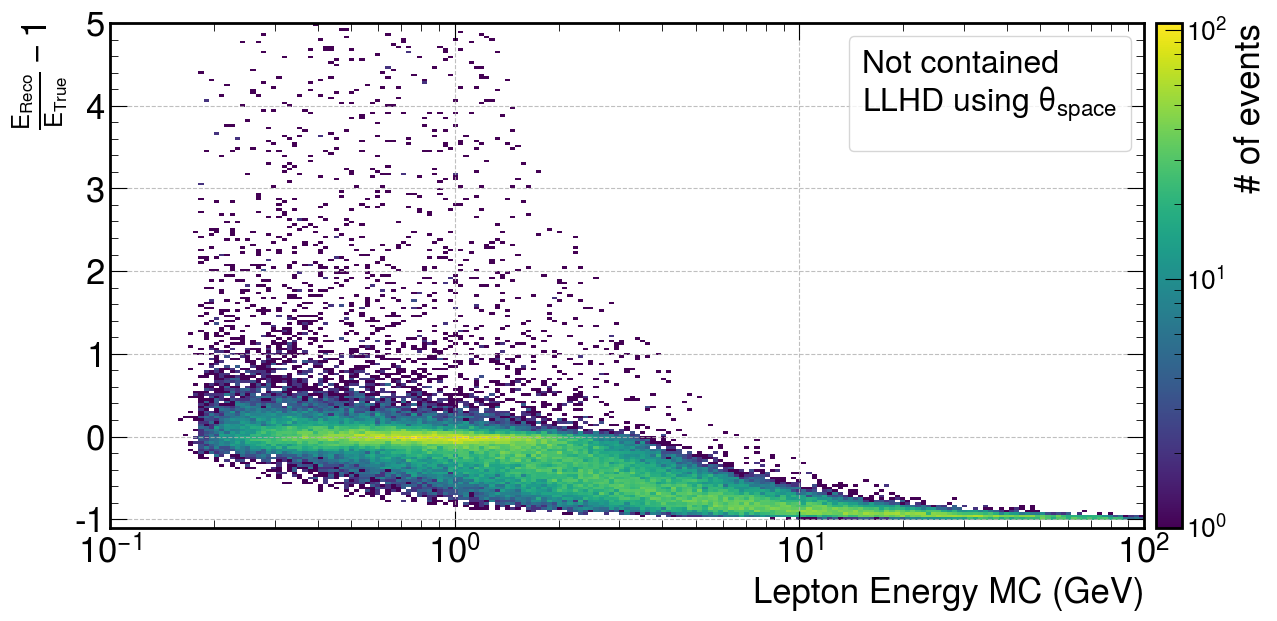

<Figure size 1400x600 with 0 Axes>

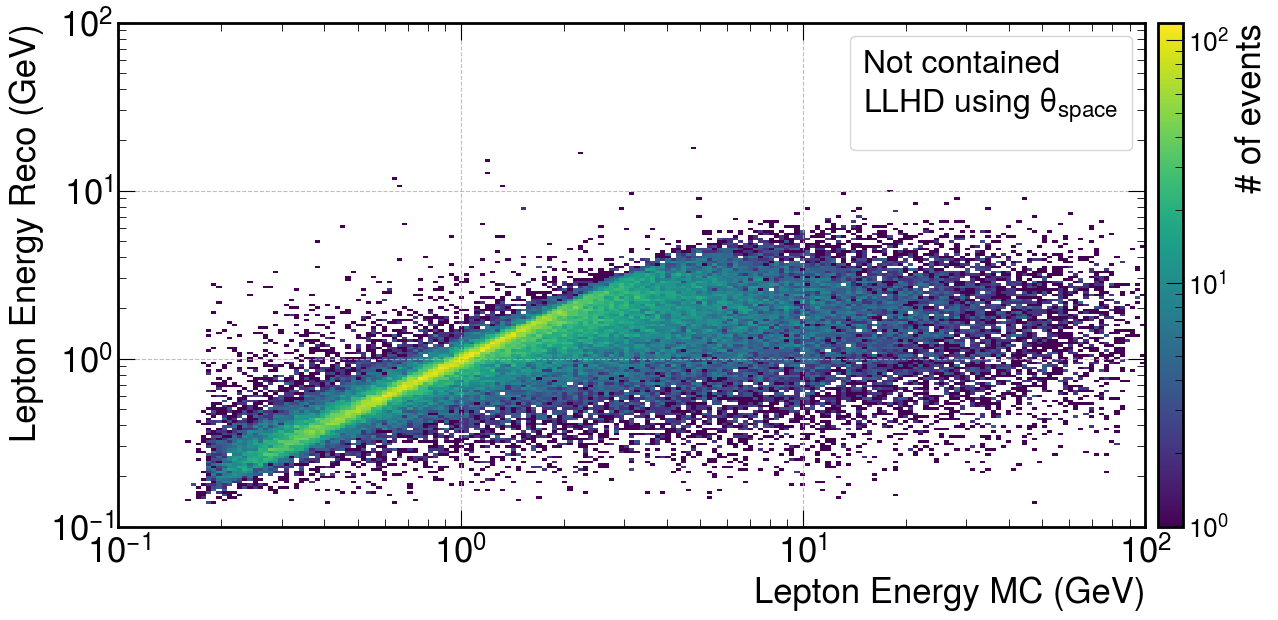

<Figure size 1400x600 with 0 Axes>

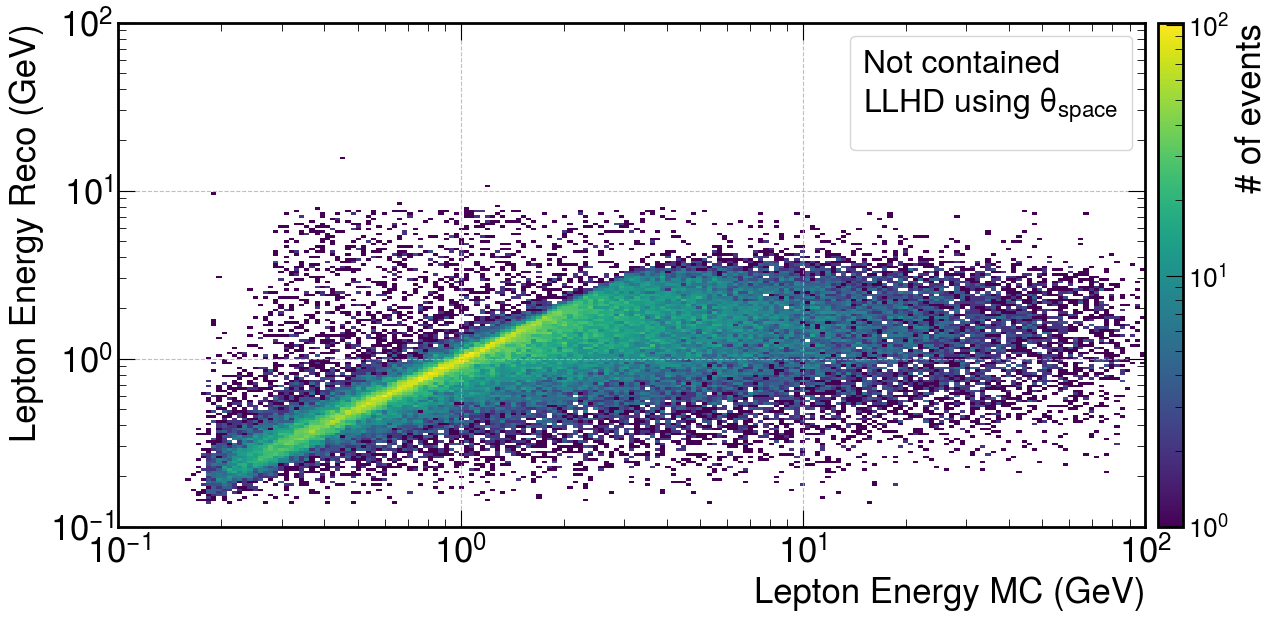

In [ ]:
def display_en_reco(x,
                    y,
                    actualx = None,
                    binse = np.logspace(-1,2,200),
                    binsy = np.linspace(-1.1,5,200),
                    xlabel = 'Lepton Energy MC (GeV)',
                    ylabel = r'$\frac{E_{Reco}}{E_{True}} - 1$',
                    fontsize=25,
                    lmethod='',
                    makefrac=True,
                    xscale='log',
                    yscale='linear',
                    figsize=(14,6.7)):
    plt.figure()
    plotx = x
    if not actualx is None:
        plotx = [v for v in actualx]
    plt.figure(figsize=figsize)
    if makefrac:
        ploty = (y/x-1)
        plt.hist2d(plotx, ploty, bins=[binse,binsy], norm='log');
    else:
        ploty = y
        plt.hist2d(plotx, ploty, bins=[binse,binsy], norm='log');
    fontsize=25
    if makefrac: plt.plot([0,100],[0,100], '--', c='r')
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)
    cbar = plt.colorbar(pad=0.01)
    cbar.ax.set_ylabel('# of events', fontsize=fontsize)
    if lmethod:
        legend = plt.legend(frameon=True, title=lmethod, loc='upper right')
    plt.plot();
display_en_reco(trueE,
                recoE,
                # actualx=recoE_nosqrt
                lmethod = r"Not contained""\n"r"LLHD using $\theta_{space}$"
                )
display_en_reco(trueEsp,
                recoEsp,
                # actualx=recoE_nosqrt
                lmethod = r"Not contained""\n"r"LLHD using $\theta_{space}$"
                )
display_en_reco(trueE,
                recoE,
                makefrac=False,
                ylabel='Lepton Energy Reco (GeV)',
                binsy=np.logspace(-1,2,200),
                yscale='log',
                lmethod = r"Not contained""\n"r"LLHD using $\theta_{space}$"
                )
display_en_reco(trueEsp,
                recoEsp,
                makefrac=False,
                ylabel='Lepton Energy Reco (GeV)',
                binsy=np.logspace(-1,2,200),
                yscale='log',
                lmethod = r"Not contained""\n"r"LLHD using $\theta_{space}$"
                )


(0.0, 75.0)

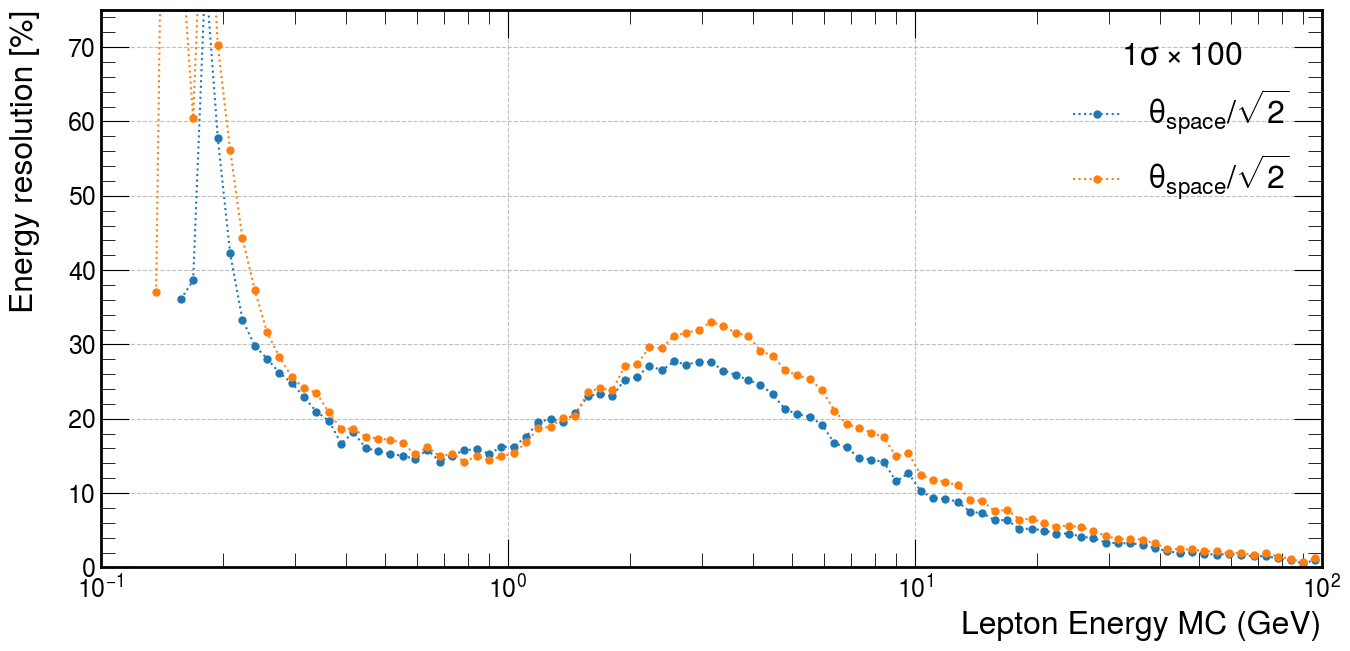

In [968]:
from scipy.stats import binned_statistic
def plot_res_vs_energy(varx, vary, actualx=None, binsx = np.logspace(-1,2,100), fmt = '.:', infotype='std', scalex='log', scaley='linear', **kwargs):
    vary = (vary/varx-1)
    if not actualx is None:
        varx = [v for v in actualx]
    if infotype=='std':
        val, _, _ = binned_statistic(varx, vary*100, manual_std, binsx)
        median, _, _ = binned_statistic(varx, vary, "median", binsx)
        ylabel = r'Energy resolution [%]'
        labelpad=20
        title = r'1$\sigma\times$100'
    else:
        val, _, _ = binned_statistic(varx, vary, infotype, binsx)
        ylabel = r'$\frac{E_{reco}}{E_{true}}-1$'
        labelpad=0
        title = 'Median'
        
    bins_center = 0.5*(binsx[:-1] + binsx[1:])
    bins_width = binsx[1:]- binsx[:-1]
    ax:plt.Axes
    ax = plt.gca()
    if 'ms' not in kwargs:
        kwargs['ms'] = 10
    lines = ax.plot(bins_center, val, fmt, **kwargs)
    ax.tick_params(which='both',labelsize=18)
    ax.tick_params(which='major',size=20)
    ax.tick_params(which='minor',size=10)
    plt.ylabel(ylabel, fontsize=23, labelpad=labelpad)
    ax.set_xscale(scalex)
    ax.set_yscale(scaley)
    # plt.axhline(20,ls='--',c='gray')
    legend = plt.legend(title=title,fontsize=23)
    plt.xlim(binsx[0],binsx[-1])
    plt.sca(ax)
    
plt.figure(figsize=[14,7])
plot_res_vs_energy(trueE,
                   recoE,
                #    binsx=np.linspace(0,4,10),
                #    scalex='linear',
                   label=r'$\theta_{space}/\sqrt{2}$')
plot_res_vs_energy(trueEsp,
                   recoEsp,
                #    binsx=np.linspace(0,4,10),
                #    scalex='linear',
                   label=r'$\theta_{space}/\sqrt{2}$',
                   )
# plot_res_vs_energy(trueEc
#                    recoEc,
#                    label=r'$\theta_{space}/\sqrt{2}$')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)
plt.ylim(0,75)
# plt.yscale('log')
# plt.savefig("angular_reco_geant.png", format='png', bbox_inches="tight", dpi=200)

(-1.0, 0.7)

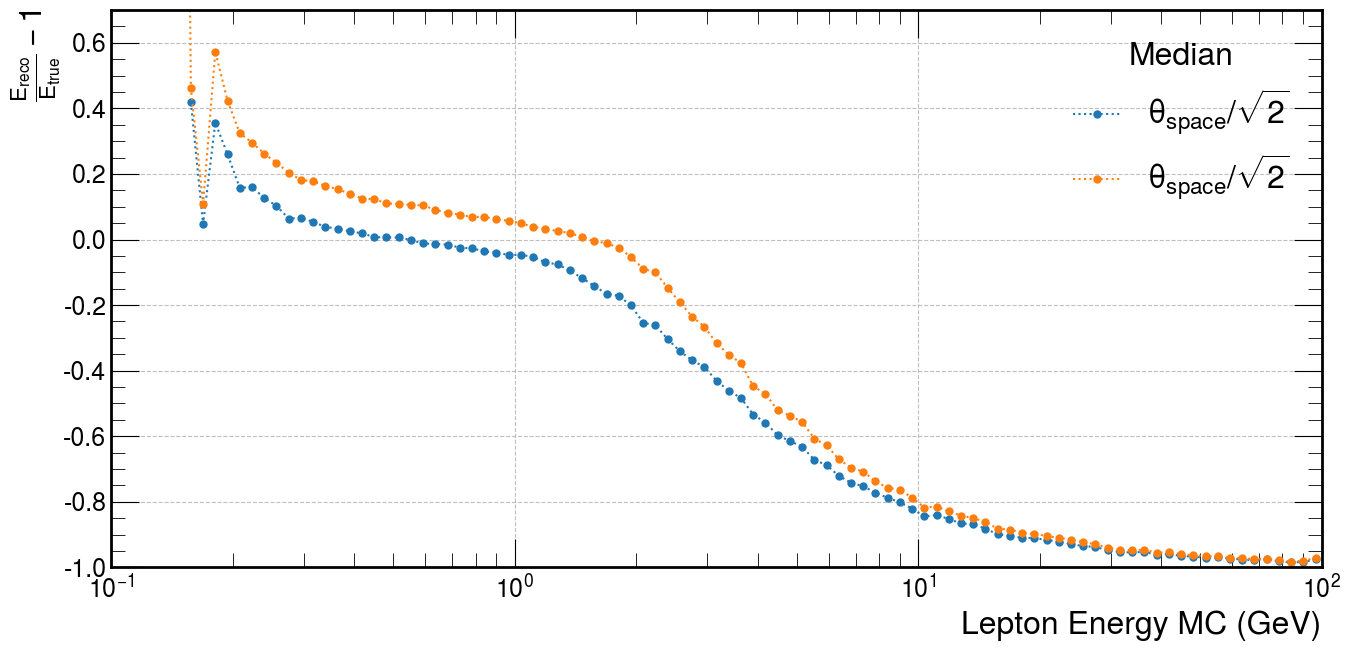

In [969]:
plt.figure(figsize=[14,7])
plot_res_vs_energy(trueE,
                   recoE,
                   infotype='median',
                #    binsx=np.linspace(0,4,10),
                #    scalex='linear',
                   label=r'$\theta_{space}/\sqrt{2}$')
plot_res_vs_energy(trueEsp,
                   recoEsp,
                   infotype='median',
                #    binsx=np.linspace(0,4,10),
                #    scalex='linear',
                   label=r'$\theta_{space}/\sqrt{2}$')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)

plt.ylim(-1,0.7)
# plt.yscale('log')

Reading nu files... 60/60
Reading geant files... 60/60
Reading reco_tracks files... 60/60

Reading pfp files... 60/60


/tmp/ipykernel_1370974/397136075.py:15: RuntimeWarning: invalid value encountered in divide
  eff = h/htot
/tmp/ipykernel_1370974/397136075.py:16: RuntimeWarning: divide by zero encountered in divide
  ereff = eff*np.sqrt(1/h + 1/htot)
/tmp/ipykernel_1370974/397136075.py:16: RuntimeWarning: invalid value encountered in multiply
  ereff = eff*np.sqrt(1/h + 1/htot)


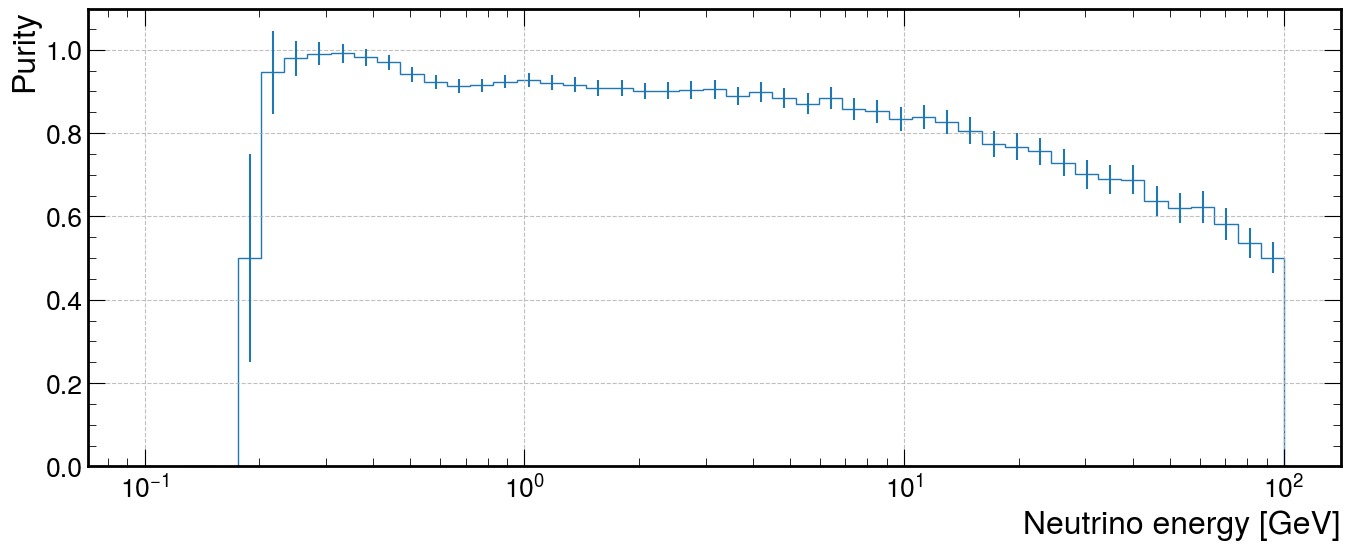

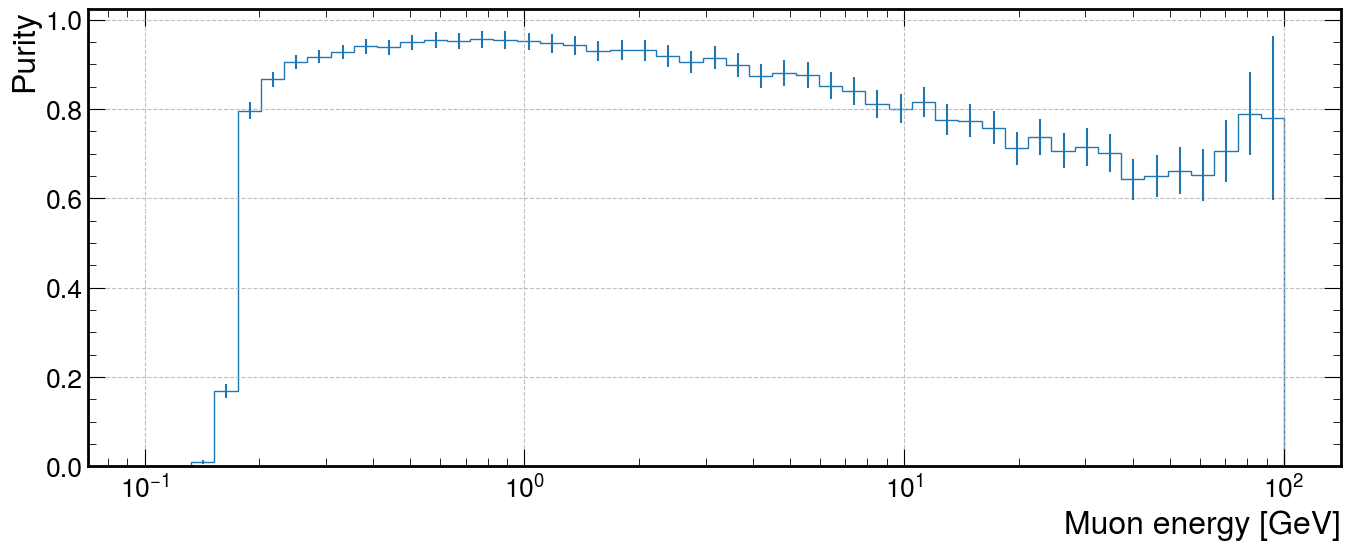

In [854]:
anadf = Anatree("",load_data=False)
anadf.read_parquet(fpath="../data/parquet_anatree_dump_using_reco2/")
dfnu = anadf.nu.collect()
dfnu = dfnu.select(selection_events('enu_truth'))

dfmu = mcsangle.group_by(selection_events()).agg(
    pl.all().first()
)
dfmu = dfmu.join(dfnu, on=selection_events())
dfismu = dfmu.filter(
    pl.col('trkpdg').abs()==13
)

def get_eff(htot,h):
    eff = h/htot
    ereff = eff*np.sqrt(1/h + 1/htot)
    return eff, ereff

def plot_eff(eff, ereff, xlabel):
    x = (binsx[1:]+binsx[:-1])*0.5
    p = plt.stairs(eff, binsx)
    plt.errorbar(x, eff, yerr=ereff, ls='none',marker='none', color=p.get_edgecolor())
    plt.xscale('log')
    plt.xlabel(xlabel)
    plt.ylabel('Purity')

binsx = np.logspace(-1,2,50)
hmu, edgemu = np.histogram(dfmu['enu_truth'], bins=binsx)
hismu, edgeismu = np.histogram(dfismu['enu_truth'], bins=binsx)

eff, ereff = get_eff(hmu, hismu)
plot_eff(eff,ereff, "Neutrino energy [GeV]")

plt.figure()
hmu, edgemu = np.histogram(dfmu['E'], bins=binsx)
hismu, edgeismu = np.histogram(dfismu['E'], bins=binsx)

eff, ereff = get_eff(hmu, hismu)
plot_eff(eff,ereff, "Muon energy [GeV]")


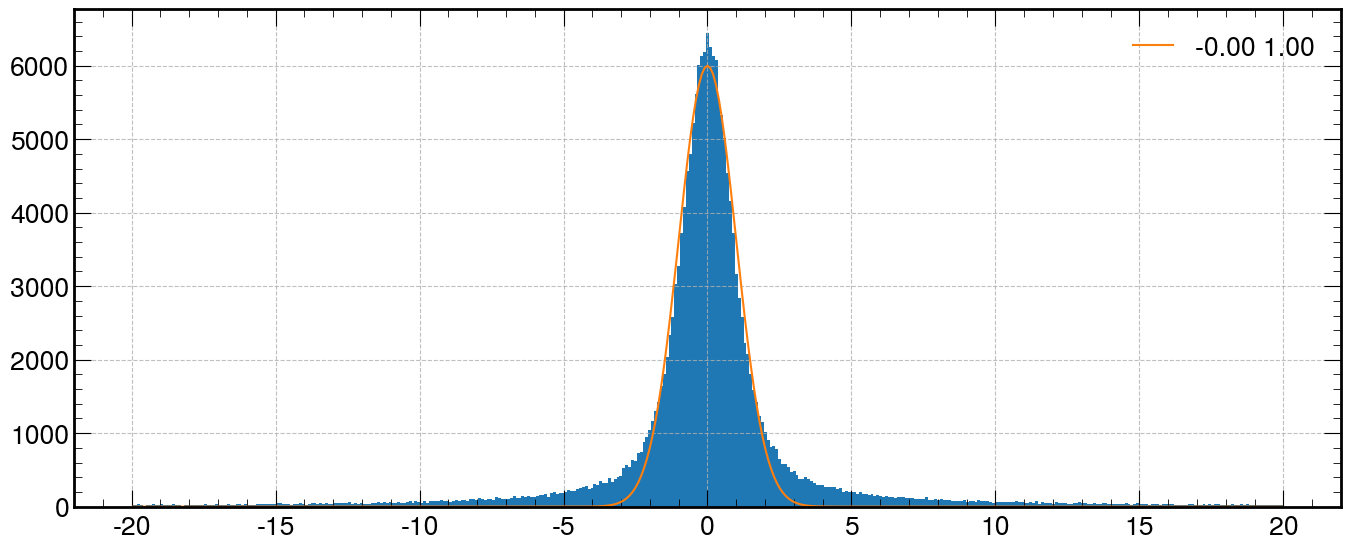

In [855]:
## Checking high energy nu angle resolution

dfhigh = mcsangle.filter(
    # pl.col('p')>5
    pl.col('isContained')==False
).filter(
    pl.col('trkpdg').abs()==13
)

dfhigh = dfhigh.group_by(selection_events()).agg(
    pl.all().head(3)
).explode(
    pl.all().exclude(selection_events())
).filter(
    pl.col('avalid')==True
)

_values = dfhigh['azx']/np.sqrt(dfhigh['rms']**2 + 0**2)
hh, hxe, _ = plt.hist(_values,bins=np.linspace(-20,20,400));
hxc = (hxe[:-1]+hxe[1:])*0.5
popt, pcov = curve_fit(gaus, hxc, hh, p0=[0,0.2,2000])
plt.plot(hxc, gaus(hxc, *popt), label=r"%.2f %.2f" % tuple(popt[:2]))
plt.legend()

# plt.hist(dfhigh['theta'],bins=500);